**Description**: Demonstrates that subsampling / replicating within each dataset is
important. Data comes from running `meta.py`.

**Estimated runtime**: ~5 sec.

In [1]:
from typing import Literal

import numpy as np
import polars as pl
import seaborn as sns

import matplotlib.pyplot as plt

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

In [3]:
num_test: Literal[200, 500] = 200

In [4]:
treatment, control = "test", "extra"
desc = "evaluation bias"

In [5]:
df = pl.read_csv(f"meta_{num_test}_treatment.csv")

In [6]:
title = (
    f"$\\mathbf{{No\:replication}}$, "
    f"$n={num_test}$, {desc} "
    f"({utils.diffco_texa(treatment, control)})"
)

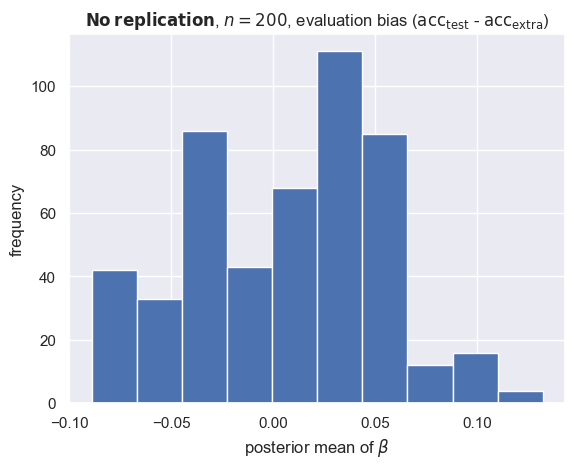

In [7]:
plt.hist(df["mean"], bins=10)
plt.title(title)
plt.xlabel(f"posterior mean of $\\beta$")
plt.ylabel("frequency");

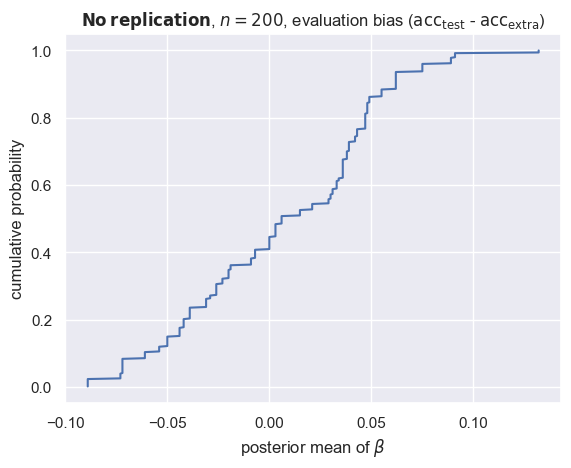

In [8]:
plt.plot(df["mean"].sort(), np.arange(1, len(df) + 1) / len(df))
plt.title(title)
plt.xlabel(f"posterior mean of $\\beta$")
plt.ylabel("cumulative probability");